In [1]:
# Import existing code modules
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from descartes import PolygonPatch
import matplotlib.path as mplPath
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask
import geocat.viz as gv

C:\Users\Samuel-NUIST\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
temp = xr.open_dataset('C:/Diabatic_data/MONTHS/dfhr/dhr1_mon_2001-2019.nc')
temp
#temp.data_vars

<xarray.Dataset>
Dimensions:  (lon: 288, lat: 145, lev: 1, time: 228)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lev      (lev) float64 9.5e+04
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2019-12-01
Data variables:
    dfhr     (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.5.3 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Sun May 14 16:46:55 2023: cdo selyear,2001/2019 dfhr1_mon_1...
    CDO:          Climate Data Operators version 1.5.3 (http://code.zmaw.de/p...

In [480]:
# select at a height
ds = temp.sel(height=2) #selecting to the pressure level
#ds

In [481]:
ds.coords['lon']=(ds.coords['lon']+180)%360-180
ds=ds.sortby(ds.lon)

In [482]:
#specify the period of interest
ds2= ds.sel(time=slice("2001-01-01", "2019-12-01"))
ds3= ds.sel(time=slice("1961-01-01", "2021-12-01"))

In [483]:
#compute climatology
AA=ds2.mean('time')
BB=ds3.mean('time')

#or
#ds2=ds1.air_temp.groupby('time.year').mean('time')
#AA=ds2.mean('year')
#diff.air_temp.plot()

In [484]:
SAM = AA -BB

In [485]:
sf2 = shp.Reader('D://Folder_2023//GIS_DATA//Oceans_disolved//Oceans_dissolved.shp')

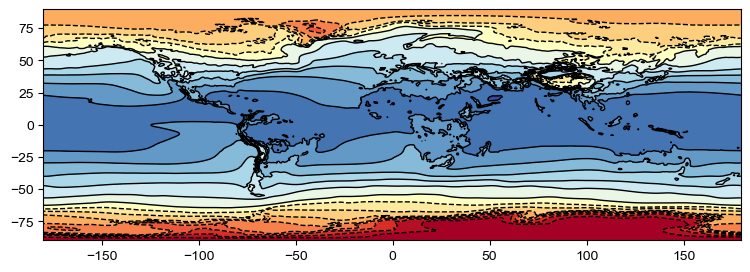

In [486]:
# Start figure
fig = plt.figure(figsize=(9, 3))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
#gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

cs = plt.contourf(BB.lon, BB.lat, BB.air_temp, cmap=plt.cm.RdYlBu, 
                  levels=np.arange(-40, 40, 5),extend='both')

## title attributes
cx = plt.contour(BB.lon, BB.lat, BB.air_temp,levels=np.arange(-40, 40, 5),  colors='k', linewidths=1)

In [487]:
# for wind vector plot
d4 = xr.open_dataset('C:/Diabatic_data/extra2/uvwind/anom_uvwind1_2001-2019.nc')
ds1 = d4.sel(lev=85000) #selecting to the pressure level
#d5.var

In [488]:
ds1.coords['lon']=(ds1.coords['lon']+180)%360-180
d5=ds1.sortby(ds1.lon)
#d5.u.plot()
#d5

In [489]:
#Make an average of the wind variables
wspd_wind = np.mean(np.sqrt(np.add(np.square(d5.u),np.square(d5.v))),axis=0)
u_wind = np.mean(d5.u,axis=0)
v_wind = np.mean(d5.v,axis=0)
#u_wind

In [490]:
#setting up the quiver arguments (these display the wind vectors on the plot)
xx_wind = wspd_wind.lon.values
yy_wind = wspd_wind.lat.values
X_wind,Y_wind =np.meshgrid(xx_wind, yy_wind)
U_wind = u_wind.data
V_wind = v_wind.data

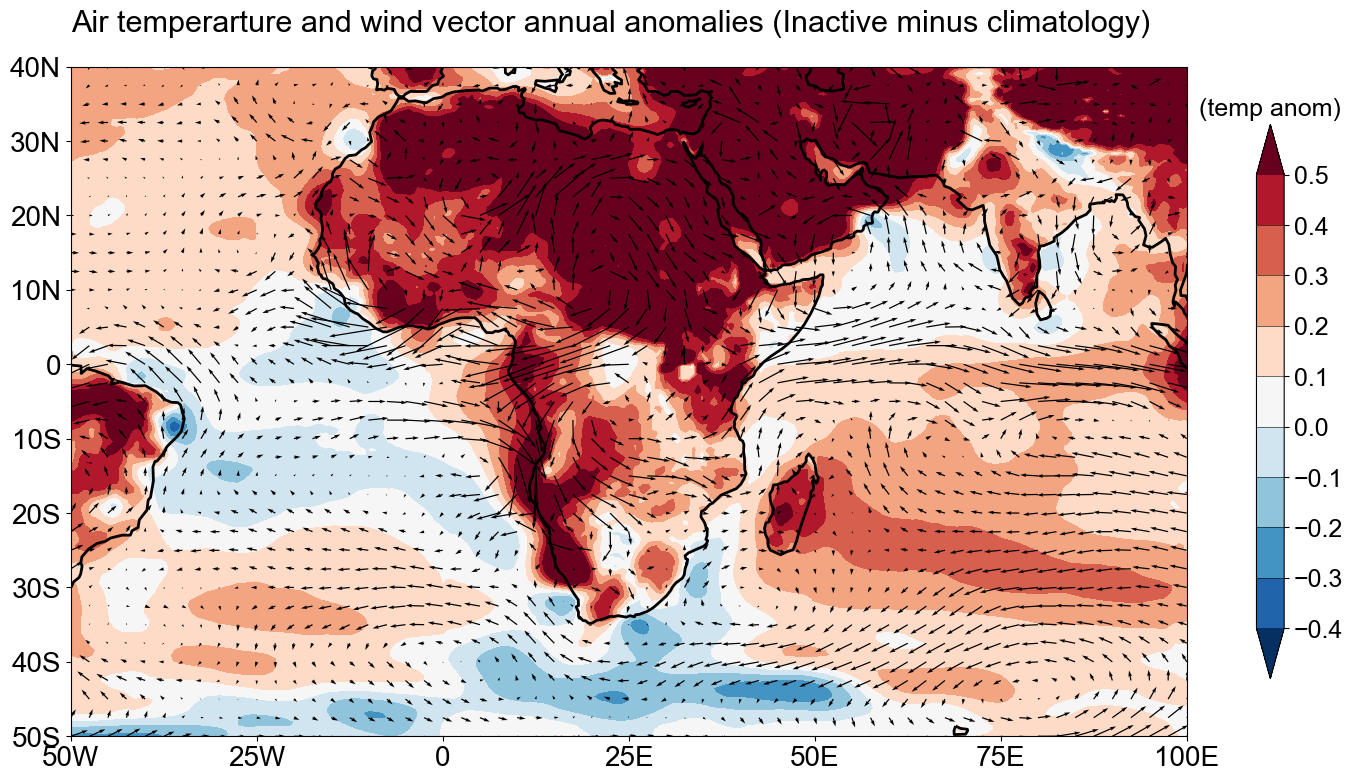

In [491]:
##### plotting
# Create a wider than normal figure to support our many plots
fig = plt.figure(figsize=(18,9))
plt.gcf().subplots_adjust(hspace=0.1, wspace=1)
plt.rcParams["font.family"] = "Arial"



def Plot(row, col, pos, diff, diff_sig, clevs, cbar_label, title):
    # Generate axes, using cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()#(central_longitude=0)
    ax = fig.add_subplot(row, col, pos, projection=projection)
    #plt.xlim([-50, 100])
    #plt.ylim([-50, 40])
    #plt.gca().set_yticks(np.arange(-50,50,20),crs=ccrs.PlateCarree())
    #plt.gca().set_xticks(np.arange(-50,110,25),crs=ccrs.PlateCarree())
    plt.xlim([-50, 100])
    plt.ylim([-50, 40])
    plt.gca().set_yticks(np.arange(-50,50,10),crs=ccrs.PlateCarree())
    plt.gca().set_xticks(np.arange(-50,110,25),crs=ccrs.PlateCarree())
    lon_formatter=LongitudeFormatter(degree_symbol=''); lat_formatter=LatitudeFormatter(degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter); ax.yaxis.set_major_formatter(lat_formatter);ax.tick_params(labelsize=20)
    xticks = ax.xaxis.get_major_ticks(); xticks[2].set_visible(True)
    
   # ax.coastlines(resolution='10m', color='black',linewidth=10)
    #ax.coastlines(resolution='10m', color='black', linewidth=0.7)
    #ax.add_feature(cfeature.BORDERS, linewidth=0.1)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Contourf-plot data
    temp = SAM.air_temp.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=clevs,
                           cmap=plt.cm.RdBu_r,
                           add_colorbar=False,
                           extend='both')
    
    #ax.coastlines(resolution='10m', color='black',linewidth=1)
    ax.coastlines(linewidth=2)
   # ax.add_feature(cfeature.BORDERS, linewidth=1)
     # Plot Hatch
    #pval = diff_sig
    #cond = (pval <= 0.05)
    ## Mask out the areas that do not satisfy the conditions
    #sig = pval.where(cond)
    
    ## make a hatch of significance
    #plt.contourf(sig.lon,sig.lat,sig,hatches=['...'],alpha=0,
    #             transform=ccrs.PlateCarree()) 
    
        # Add color bar
    cbar = plt.colorbar(temp,
                        orientation='vertical',
                        shrink=0.8,
                        extendfrac='auto', 
                        extendrect=False, 
                        drawedges=True)

    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(clevs)
    cbar.ax.set_title(cbar_label, size=18)

    # Use geocat.viz.util convenience function to set titles and labels without calling several matplotlib functions
    gv.set_titles_and_labels(ax,
                            maintitle="",
                            lefttitle=title,
                            lefttitlefontsize=22,
                            righttitle="",
                            righttitlefontsize=22,
                            xlabel="",
                            ylabel="")


# define the levels for each variable
#clevs  = [18,20,22, 24, 26, 28, 30]
clevs  = [-0.4 ,-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
Plot(1,1,1,1,  SAM,  clevs, '(temp anom)', "Air temperarture and wind vector annual anomalies (Inactive minus climatology)")

#plt.quiver(X_wind[::3, ::3], Y_wind[::3, ::3], U_wind[::3, ::3], V_wind[::3, ::3], 
#           transform=ccrs.PlateCarree(), color='k', scale=30, width=0.0011,)
plt.quiver(X_wind[::2, ::2], Y_wind[::2, ::2], U_wind[::2, ::2], V_wind[::2, ::2], 
           transform=ccrs.PlateCarree(), color='k', scale=25, width=0.0011,)
#fig.savefig('C:/Diabatic_data/extra2/uvwind/composite_Inactive-clim_temp-wind.png', bbox_inches='tight', pad_inches = 0.1, dpi=300)
plt.show()